In [7]:
import ast
import numpy as np
import pandas as pd

import spacy
from nltk import ngrams as nltk_ngrams

from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report

import evaluate
from sentence_transformers import SentenceTransformer, util

import seaborn as sns
import matplotlib.pyplot as plt

# precision_metric = evaluate.load('precision')
# recall_metric = evaluate.load('recall')
# rouge_model = evaluate.load('rouge')
bleu_model = evaluate.load("bleu")
# bleurt_model = evaluate.load("bleurt", module_type="metric", checkpoint="bleurt-large-512")
# similarity_model = SentenceTransformer('stsb-roberta-large')

nlp = spacy.load('en_core_web_sm')

In [ ]:
df = pd.read_csv('~/active-projects/textbook-question-generation/data/aqag-chatgpt-vicuna.csv')
# df.rename({'correct_answer_vicuna': 'gold_answer'}, axis=1, inplace=True)
df.rename({'correct_answer': 'gold_answer'}, axis=1, inplace=True)
df.rename({'correct_answer_vicuna': 'correct_answer'}, axis=1, inplace=True)
# df.head()

In [ ]:
# df.shape, df.dropna(subset=['clean_text', 'question', 'correct_answer', 'incorrect_answer', 'gold_answer']).shape

In [ ]:
df.dropna(subset=['clean_text', 'question', 'correct_answer', 'incorrect_answer', 'gold_answer'], inplace=True)
# df.shape

In [ ]:
temp_correct_df = df[['clean_text', 'question', 'gold_answer', 'correct_answer']]
temp_correct_df.rename({'correct_answer': 'student_response'}, axis=1, inplace=True)
temp_correct_df['true_label'] = 1
# temp_correct_df.head()

In [ ]:
temp_incorrect_df = df[['clean_text', 'question', 'gold_answer', 'incorrect_answer']]
temp_incorrect_df.rename({'incorrect_answer': 'student_response'}, axis=1, inplace=True)
temp_incorrect_df['true_label'] = 0
# temp_incorrect_df.head()

In [ ]:
df.shape, temp_correct_df.shape, temp_incorrect_df.shape

In [ ]:
df = pd.concat([temp_correct_df, temp_incorrect_df]).reset_index(drop=True)
df.head()

#### Preprocessing

In [ ]:
# preprocessing steps for similarity computation:
# 1. lower case
# 2. remove non-alphanumeric characters except those bringing in context - (['@', '#', '$', '%', '*', '<', '>', '.', ','])
# 3. remove stopwords
# 4. lemmatize --- experiment

def func_preprocessing(text:str, lemmatize:bool=False):

    return_list = list()
    doc = nlp(text.lower().strip())
    for token in [token for token in doc]:
        if (token.text.isalnum() or any(i in token.text and token.text.count(i) == 1 for i in ['@', '#', '$', '%', '<', '>', '.', ',', '+', '-', '*'])) and (not token.is_stop):
            if lemmatize:
                return_list.append(token.lemma_)
            else:
                return_list.append(token.text)
    
    return ' '.join(return_list)

df['processed_gold_answer'] = df['gold_answer'].apply(lambda x: func_preprocessing(x))
df['processed_student_response'] = df['student_response'].apply(lambda x: func_preprocessing(x))

df['processed_lemmatized_gold_answer'] = df['gold_answer'].apply(lambda x: func_preprocessing(x, lemmatize=True))
df['processed_lemmatized_student_response'] = df['student_response'].apply(lambda x: func_preprocessing(x, lemmatize=True))

df.head()

#### Computing BLUE

In [ ]:
def compute_bleu(predictions:str, references:str):
    try:
        score = bleu_model.compute(predictions=[predictions], references=[[references]])
    except ZeroDivisionError:
        score = {'bleu': -100}
    return score

df['score'] = df.apply(lambda x: compute_bleu(predictions=x['student_response'], references=x['gold_answer']), axis=1)
df['processed_score'] = df.apply(lambda x: compute_bleu(predictions=x['processed_student_response'], references=x['processed_gold_answer']), axis=1)
df['processed_lemmatized_score'] = df.apply(lambda x: compute_bleu(predictions=x['processed_lemmatized_student_response'], references=x['processed_lemmatized_gold_answer']), axis=1)

In [ ]:
df.head()

In [2]:
# df.to_csv('~/active-projects/textbook-question-generation/data/aqag-chatgpt-vicuna-bleu.csv', index=False)
df = pd.read_csv('~/active-projects/textbook-question-generation/data/aqag-chatgpt-vicuna-bleu.csv')

In [4]:
df

,clean_text,question,gold_answer,student_response,true_label,processed_gold_answer,processed_student_response,processed_lemmatized_gold_answer,processed_lemmatized_student_response,score,processed_score,processed_lemmatized_score
0,Every day we are faced with a myriad of decisi...,How can social media alter how we make decisions?,Social media outlets like Facebook and Twitter...,Social media can alter how we make decisions b...,1,social media outlets like facebook twitter pro...,social media alter decisions providing additio...,social medium outlet like facebook twitter pro...,social medium alter decision provide additiona...,"{'bleu': 0.0, 'precisions': [0.307692307692307...","{'bleu': 0.0, 'precisions': [0.238095238095238...","{'bleu': 0.0, 'precisions': [0.285714285714285..."
1,What is economics and why should you spend you...,What is economics?,Economics is both a subject area and a way of ...,Economics is a subject area that studies how p...,1,economics subject area way viewing world .,economics subject area studies people choices ...,economic subject area way view world .,economic subject area study people choice choi...,"{'bleu': 0.0, 'precisions': [0.421052631578947...","{'bleu': 0.0, 'precisions': [0.4, 0.2222222222...","{'bleu': 0.0, 'precisions': [0.4, 0.2222222222..."
2,"By the end of this section, you will be able t...",What is scarcity?,Scarcity is a fact of life in which human want...,Scarcity refers to the limited availability of...,1,"scarcity fact life human wants goods , service...",scarcity refers limited availability resources...,"scarcity fact life human want good , service ,...","scarcity refer limited availability resource ,...","{'bleu': 0.0, 'precisions': [0.323529411764705...","{'bleu': 0.0, 'precisions': [0.291666666666666...","{'bleu': 0.0, 'precisions': [0.291666666666666..."
3,Data is very important in economics because it...,What is the name of the database where most of...,The St. Louis Federal Reserve Bank's FRED data...,The data used for this course is obtained from...,1,st . louis federal reserve bank fred database .,data course obtained st . louis federal reserv...,st . louis federal reserve bank fred database .,datum course obtain st . louis federal reserve...,"{'bleu': 0.435949382480739, 'precisions': [0.5...","{'bleu': 0.7102992180127422, 'precisions': [0....","{'bleu': 0.7102992180127422, 'precisions': [0...."
4,"Think about all the things you consume: food, ...",What economic principle does Adam Smith first ...,Division and specialization of labor.,Adam Smith first put forth the division and sp...,1,division specialization labor .,adam smith forth division specialization labor...,division specialization labor .,adam smith forth division specialization labor...,"{'bleu': 0.10414419091986513, 'precisions': [0...","{'bleu': 0.0, 'precisions': [0.307692307692307...","{'bleu': 0.0, 'precisions': [0.307692307692307..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2923,The World Trade Organization (WTO) was officia...,What is the old joke about GATT?,GATT stands for Gentlemen's Agreement to Talk ...,GATT stands for General Agreement on Tariffs a...,0,gatt stands gentlemen agreement talk talk .,gatt stands general agreement tariffs trade .,gatt stand gentleman agreement talk talk .,gatt stand general agreement tariff trade .,"{'bleu': 0.0, 'precisions': [0.6, 0.2222222222...","{'bleu': 0.0, 'precisions': [0.571428571428571...","{'bleu': 0.0, 'precisions': [0.571428571428571..."
2924,There are different types of economic integrat...,What is the main purpose of the European Union?,The main purpose of the European Union is to e...,The main purpose of the European Union is to i...,0,main purpose european union eliminate barriers...,main purpose european union introduce common c...,main purpose european union eliminate barrier ...,main purpose european union introduce common c...,"{'bleu': 0.3577946837351794, 'precisions': [0....","{'bleu': 0.20544097977075837, 'precisions': [0...","{'bleu':

In [8]:
df['score'] = df['score'].apply(lambda x: ast.literal_eval(x))
df['processed_score'] = df['processed_score'].apply(lambda x: ast.literal_eval(x))
df['processed_lemmatized_score'] = df['processed_lemmatized_score'].apply(lambda x: ast.literal_eval(x))

<Axes: ylabel='Frequency'>

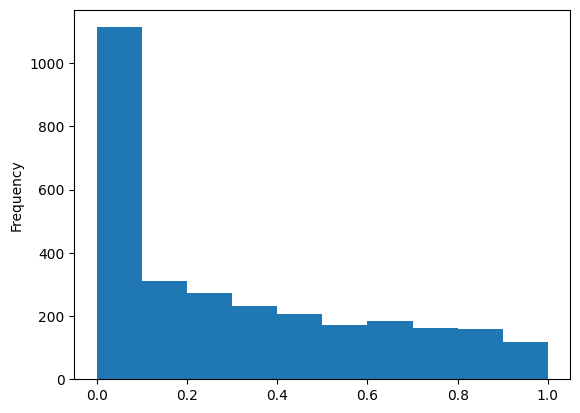

In [10]:
df['score'].apply(lambda x: x['bleu']).plot(kind='hist')

<Axes: ylabel='Frequency'>

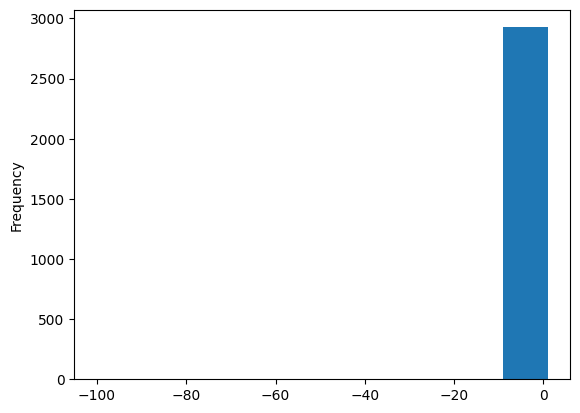

In [11]:
df['processed_score'].apply(lambda x: x['bleu']).plot(kind='hist')

<Axes: ylabel='Frequency'>

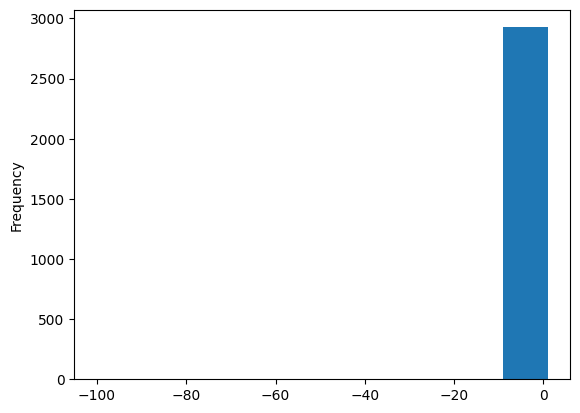

In [12]:
df['processed_lemmatized_score'].apply(lambda x: x['bleu']).plot(kind='hist')

In [14]:
df['label'] = df['score'].apply(lambda x: 1 if x['bleu']>0.5 else 0)
df['processed_label'] = df['processed_score'].apply(lambda x: 1 if x['bleu']>0.5 else 0)
df['processed_lemmatized_label'] = df['processed_lemmatized_score'].apply(lambda x: 1 if x['bleu']>0.5 else 0)

In [15]:
confusion_matrix(df['true_label'], df['label'])

array([[ 944,  520],
       [1194,  270]])

In [16]:
print(classification_report(df['true_label'], df['label']))

              precision    recall  f1-score   support

           0       0.44      0.64      0.52      1464
           1       0.34      0.18      0.24      1464

    accuracy                           0.41      2928
   macro avg       0.39      0.41      0.38      2928
weighted avg       0.39      0.41      0.38      2928



In [17]:
cohen_kappa_score(df['true_label'], df['label'])

-0.1707650273224044

In [18]:
confusion_matrix(df['true_label'], df['processed_label'])

array([[1100,  364],
       [1194,  270]])

In [19]:
print(classification_report(df['true_label'], df['processed_label']))

              precision    recall  f1-score   support

           0       0.48      0.75      0.59      1464
           1       0.43      0.18      0.26      1464

    accuracy                           0.47      2928
   macro avg       0.45      0.47      0.42      2928
weighted avg       0.45      0.47      0.42      2928



In [20]:
cohen_kappa_score(df['true_label'], df['processed_label'])

-0.06420765027322406

In [21]:
confusion_matrix(df['true_label'], df['processed_lemmatized_label'])

array([[1096,  368],
       [1181,  283]])

In [22]:
print(classification_report(df['true_label'], df['processed_lemmatized_label']))

              precision    recall  f1-score   support

           0       0.48      0.75      0.59      1464
           1       0.43      0.19      0.27      1464

    accuracy                           0.47      2928
   macro avg       0.46      0.47      0.43      2928
weighted avg       0.46      0.47      0.43      2928



In [23]:
cohen_kappa_score(df['true_label'], df['processed_lemmatized_label'])

-0.05806010928961758